# Estudio de sismos 
#### Descripción:
A continuación se realizó un analisis detallado de una base de datos de sismos en italía, para luego usar metodos no supervisados de clustering con el objetivo de observar una separación entre las ondas S y las ondas superficiales pues en muchos casos estas dependen de la profundidad y la magnitud registrada. Se plantea el uso de Dbscan con distancia de mahalanobis pues el Dbscan es un agrupamiento basado en la densidad de puntos en un espacio, y la distancia de mahalanobis se define como la distancia de un punto a una distribución estadistica de cierta media. Por lo que se podría observar de buenas a primeras si las variables puedan presentar alguna caracteristica que identique este agrupamiento. La base de datos tiene 5 columnas Time(tiempo), Longitude (Longitud), Latitude (Latitud), Depth/Km (profundidad en kilometros) y Magnitude (Magnitud en escala de Ricther). Además de contar con poco mas de 8000 filas. 

In [185]:
#se importan las librerias para la lectura 
#y procesamiento preliminar de los datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
import statsmodels.api as sm 

Se lee el archivo y se visualizan sus cabecera para identificar las columnas y además se realizan los histogramas de cada variable para observar como se distribuyen

In [186]:
Filepath= r"Dataset.csv"
df=pd.read_csv(Filepath)
print(df.head())

                      Time  Latitude  Longitude  Depth/Km  Magnitude
0  2016-08-24 03:36:32.000   42.6983    13.2335       8.1        6.0
1  2016-08-24 03:37:26.580   42.7123    13.2533       9.0        4.5
2  2016-08-24 03:40:46.590   42.7647    13.1723       9.7        3.8
3  2016-08-24 03:41:38.900   42.7803    13.1683       9.7        3.9
4  2016-08-24 03:42:07.170   42.7798    13.1575       9.7        3.6


<AxesSubplot:xlabel='Latitude', ylabel='Count'>

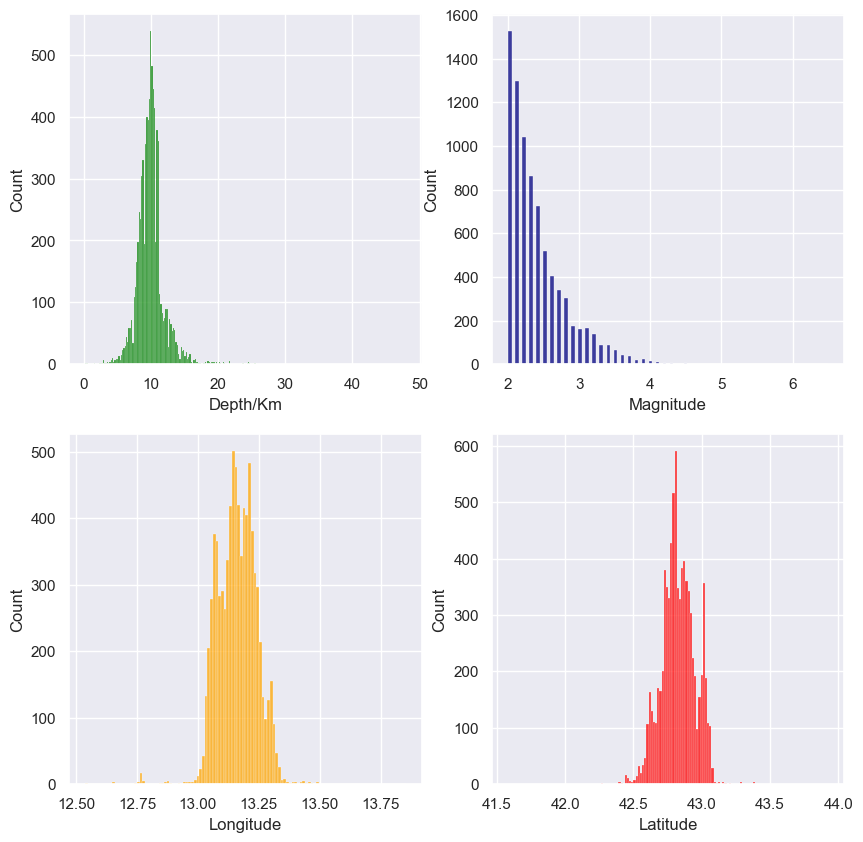

In [187]:
#Se inicializa un set en seaborn y se hace una cuadricula de 2 filas y 2 columna 
#Para cuatro tramas.
sns.set()
ghist, axes = plt.subplots(2, 2, figsize=(10,10))
sns.histplot(data=df,x='Depth/Km',ax=axes[0,0],color='green')
sns.histplot(data=df,x='Magnitude',ax=axes[0,1],color='navy')
sns.histplot(data=df,x='Longitude',ax=axes[1,0],color='orange')
sns.histplot(data=df,x='Latitude',ax=axes[1,1],color='red')

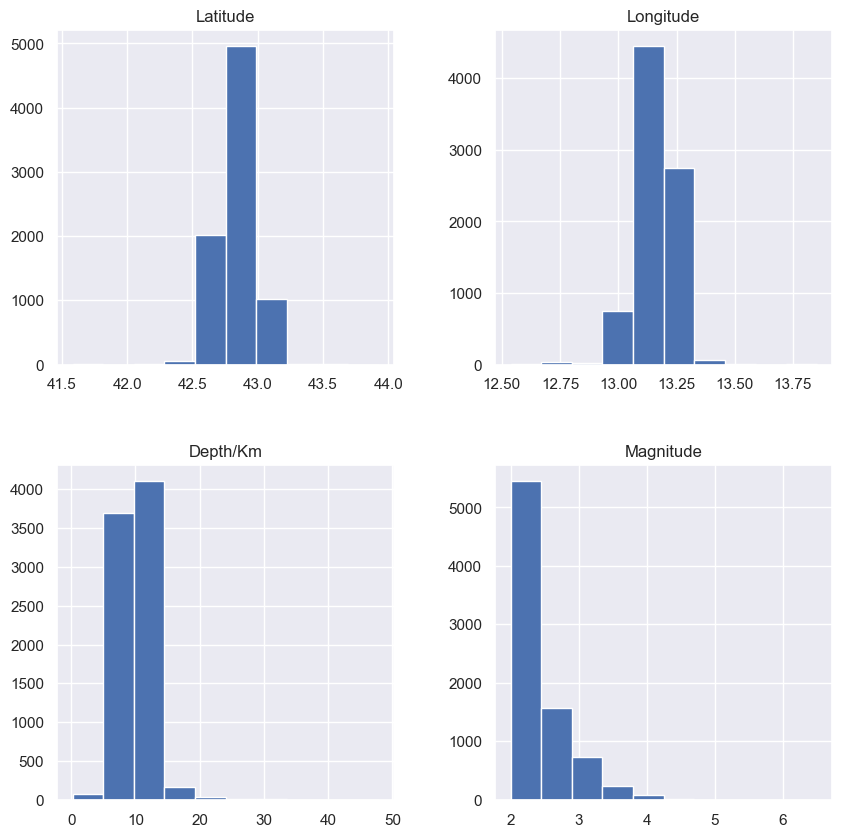

In [188]:
df.iloc[:,:].hist(figsize=(10,10))
plt.show()

## Analisis Exploratorio de Datos (EDA) 
Despues de observar la distribución de los histogramas se organizan los datos para realizar un analisis exploratorio, en primer lugar se hace la matris de correlación de pearson para ver si se tiene o no una dependencia lineal entre las variables

<AxesSubplot:title={'center':'Mapa de calor con respecto \n a la correlación de la base de datos'}>

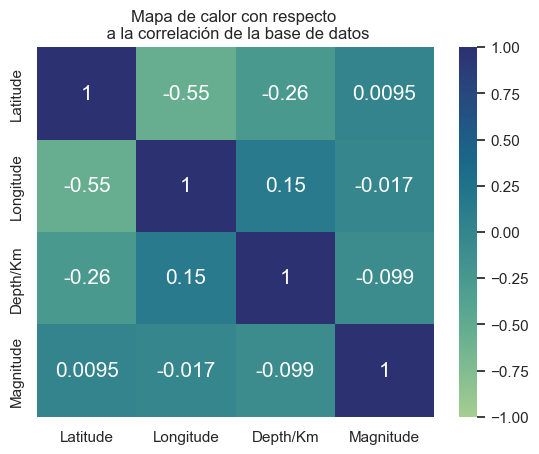

In [190]:
#Matriz de correlación calculada con metodo pearson solo numericos flotantes
#Con un mapa de color con valor minimo -1 (inversamente proporcional) , y valor maximo 1 (directamente proporcional)
matriz=df.corr(method='pearson',numeric_only=float)
plt.title('Mapa de calor con respecto \n a la correlación de la base de datos')
sns.heatmap(matriz,cmap='crest',annot=True,
           annot_kws={'fontsize':15}
           ,vmin=-1,vmax=1)

Tambien se realizan diagramas de caja y bigote para observar si se distribuyen simetricamente, además de poder observar si se presentan outliers, Despues se realizan diagramas de dispersión con respecto a la magnitud para ver si esta ultima depende de alguna manera con respecto a las demas variables

<AxesSubplot:ylabel='Latitude'>

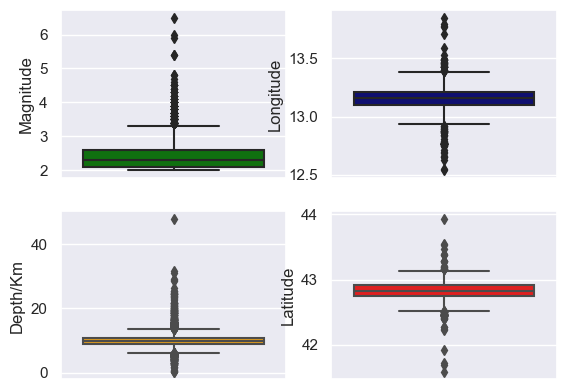

In [191]:
sns.set()
gbox, axes = plt.subplots(2, 2)
sns.boxplot(data=df,y='Magnitude',ax=axes[0,0],color='green')
sns.boxplot(data=df,y='Longitude',ax=axes[0,1],color='navy')
sns.boxplot(data=df,y='Depth/Km',ax=axes[1,0],color='orange')
sns.boxplot(data=df,y='Latitude',ax=axes[1,1],color='red')

<AxesSubplot:xlabel='Latitude', ylabel='Magnitude'>

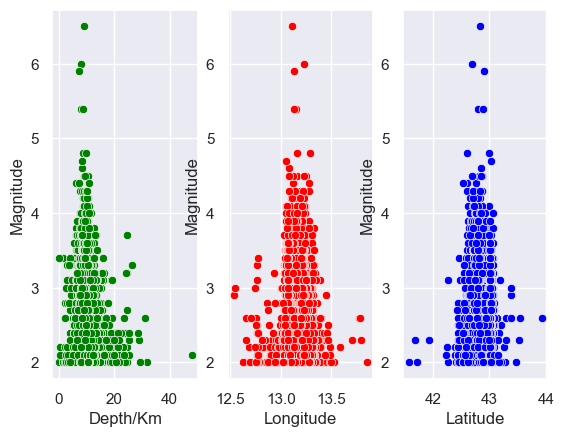

In [13]:
sns.set()
gscar2, axes = plt.subplots(1, 3)
sns.scatterplot(data=df,x='Depth/Km',y='Magnitude',ax=axes[0],color='green')
sns.scatterplot(data=df,x='Longitude',y='Magnitude',ax=axes[1],color='red')
sns.scatterplot(data=df,x='Latitude',y='Magnitude',ax=axes[2],color='blue')
#sns.scatterplot(data=df,x='Depth/Km',y='Magnitude',ax=axes[1,1],color='yellow')

Se realizan graficas q-q con la distribución t de student con respecto a sus cuantiles, como se puede observar los datos tienden a la distribución antes mencionada, la magnitud se ajusta mejor a la normal. Con esto podemos tomar la desición de escalar los datos con Z-score
# $Z=\frac{x_{i}-\bar{x}}{\sigma}$
Este escalado mantiene la media poblacional en 0 y transforma la varianza en 1, tanto para reducir la influencia de los datos atipicos, como regular la varianza de los datos. Además esto mantiene todas las columnas en una escala en la cual pueden ser comparadas unas a otras.

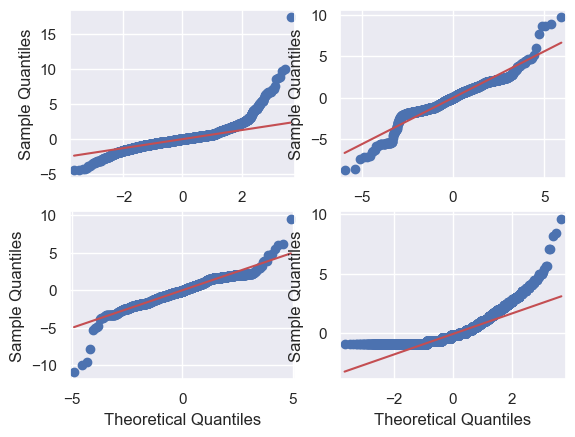

In [208]:
#Graficas q-q con la distribucion t stundent de la Profundidad, Longitud , Latitud, y Magnitud
sns.set()
gqdur, axes = plt.subplots(2, 2)
sm.qqplot(data=df['Depth/Km'] , dist=stats.t ,fit=True ,ax=axes[0,0], line= 'q')
sm.qqplot(data=df['Longitude'] , dist=stats.t ,fit=True ,ax=axes[0,1], line= 'q')
sm.qqplot(data=df['Latitude'] , dist=stats.t ,fit=True ,ax=axes[1,0], line= 'q')
sm.qqplot(data=df['Magnitude'] , dist=stats.norm, fit=True ,ax=axes[1,1], line= 'q')
plt.savefig('qq.png')

Se toman las variables en dos vectores uno para entrenar y hacer el clustering con datos aleatorios (tambien en caso de cambiar de metodo para tener de una vez el conjunto de entrenamiento) y otro para seguir con el analisis exploratorio de datos 

In [27]:
#X datos de entrenamiento y clustering
#XN datos para realizar el Analisis exploratorio de datos normalizado
X=df.iloc[:,[1,2,3,4]]
XN=df.iloc[:,[1,2,3,4]]
Y=df.iloc[:,[4]]

Se llama a la funcion de preprocesamiento de sklearn y al objeto StandarScaler el cual hace el escalamiento de Zscore

In [200]:
from sklearn.preprocessing import StandardScaler
#se inicializa el escalador y se ajustanlos datos de entrada
ScalerP=StandardScaler().fit(XN)
#se ejecuta el escalado sobre los datos de entrada
X_scaled=ScalerP.transform(XN)
# se retorna un vector con los valores escalados

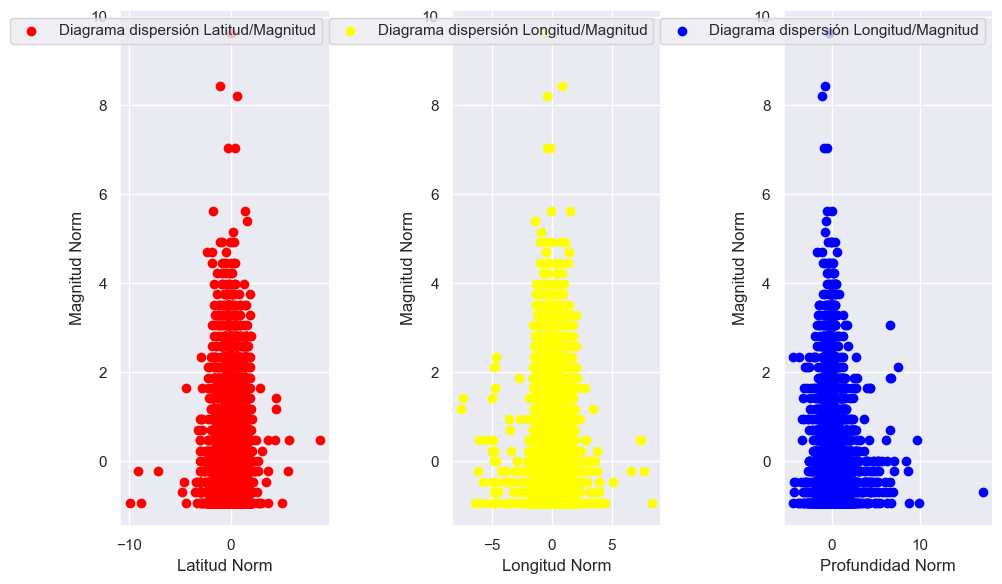

In [205]:
#se realizan diagramas de dispersión con respecto a la magnitud de las variables normalizadas (la magnitud tambien esta normalizada)
x_transformedLat = X_scaled[:, 0]
x_transformedLon = X_scaled[:, 1]
x_transformedDepth = X_scaled[:, 2]
x_transformedMag = X_scaled[:, 3]

figsca, axsca = plt.subplots(nrows=1,ncols=3, figsize=(10,6))

axsca[0].scatter(x_transformedLat, x_transformedMag , label='Diagrama dispersión Latitud/Magnitud' ,color='red')
axsca[0].set_xlabel('Latitud Norm')
axsca[0].set_ylabel('Magnitud Norm')
axsca[0].legend()

axsca[1].scatter(x_transformedLon, x_transformedMag , label='Diagrama dispersión Longitud/Magnitud',color='yellow')
axsca[1].set_xlabel('Longitud Norm')
axsca[1].set_ylabel('Magnitud Norm')
axsca[1].legend()

axsca[2].scatter(x_transformedDepth, x_transformedMag , label='Diagrama dispersión Longitud/Magnitud',color='blue')
axsca[2].set_xlabel('Profundidad Norm')
axsca[2].set_ylabel('Magnitud Norm')
axsca[2].legend()

figsca.tight_layout()
plt.savefig('figsca.png')
plt.show()

Una vez se tienen los datos normalizados se realiza una aproximación con la distribución t de student para todas las variables, al realizar las graficas observamos a que puntos de frecuencia llegan con la respectiva distribución y luego se evaluara cada aproximación normalizada con los datos normalizados en una prueba chi-cuadrada

In [39]:
#esta funcion toma un vector y la distribución a la cual se desea ajustar y retorna la variable aproximada y
def AproxGrafNorm(a,distri):
    dist2=distri
    par=dist2.fit(data=a)
    xn=np.linspace(a.min(),a.max(),len(df))
    yn=dist2.pdf(xn,*par)
    return xn,yn,par
#Se toman todos los valores X y Y normalizados y aproximados para luego ser evaluados con la prueba de hipotesis chi-cuadrada
XnMag,YnMag,ParMag= AproxGrafNorm(x_transformedMag,stats.t)
XnDepth,YnDepth,ParDepth= AproxGrafNorm(x_transformedDepth,stats.t)
Xnlon,Ynlon,Parlon= AproxGrafNorm(x_transformedLon,stats.t)
Xnlat,Ynlat,Parlat= AproxGrafNorm(x_transformedLat,stats.t)

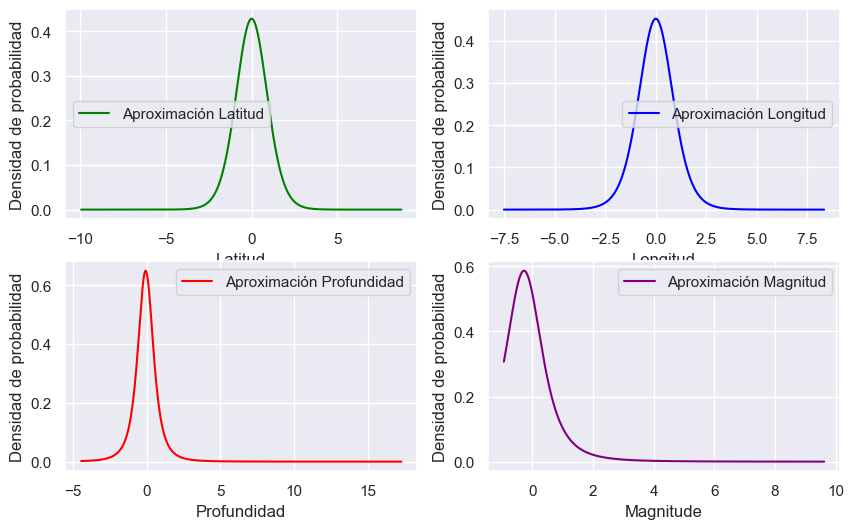

In [206]:
#Aqui se hacen las graficas 
figap, axs= plt.subplots(nrows=2,ncols=2,figsize=(10,6))

axs[0,0].plot(Xnlat,Ynlat,label='Aproximación Latitud',color='green')
axs[0,0].set_xlabel('Latitud')
axs[0,0].set_ylabel('Densidad de probabilidad')
axs[0,0].legend()

axs[0,1].plot(Xnlon,Ynlon,label='Aproximación Longitud',color='blue')
axs[0,1].set_xlabel('Longitud')
axs[0,1].set_ylabel('Densidad de probabilidad')
axs[0,1].legend()


axs[1,0].plot(XnDepth,YnDepth,label='Aproximación Profundidad',color='red')
axs[1,0].set_xlabel('Profundidad')
axs[1,0].set_ylabel('Densidad de probabilidad')
axs[1,0].legend()

axs[1,1].plot(XnMag,YnMag,label='Aproximación Magnitud',color='purple')
axs[1,1].set_xlabel('Magnitude')
axs[1,1].set_ylabel('Densidad de probabilidad')
axs[1,1].legend()

fig.tight_layout()
plt.savefig('Aprox.png')
plt.show()

Se realiza la prueba chi-cuadrado donde su hipotesis nula consiste en que el valor el valor aproximado es igual a la frecuencia de ese valor en la distribución chi-cuadrada de los datos originales, y su estadistico nos muestra la distancia concreta de la aproximación a la verdadera distribución de la población

In [42]:
from scipy.stats import chisquare
exp=Ynlon
exl=Ynlat
exm=YnMag
chiLon,pLon= chisquare(x_transformedLon, f_exp=exp)
print("El error estadistico con respecto a la longitud normalizada es de :",chiLon)
print(pLon)

El error estadistico con respecto a la longitud normalizada es de : 235195524.48272958
0.0


In [43]:
chilat, pLat= chisquare(x_transformedLat, f_exp=exl)
print("El error estadistico con respecto a la latitud normalizada es de :",chilat)

El error estadistico con respecto a la latitud normalizada es de : 17208972444.67203


In [44]:
chim, pm= chisquare(x_transformedMag, f_exp=exm)
print("El error estadistico con respecto a la magnitud normalizada es de :",chim)

El error estadistico con respecto a la magnitud normalizada es de : 10102495.254177652


In [45]:
#TO-DO
#-Organizar el codigo con comentarios y markdowns

# Clustering con DBSCAN
## Con uso de la distancia de mahalanobis:
El metodo de clustering con DBSCAN se basa en la densidad de los puntos en un 'plano' se dice que un punto puede ser centro de un clustering si cumple con que la cantidad minima de vecinos tengan una distancia menor o igual que epsilon, En este caso particular se definira la distancia de estos puntos no de manera euclidana si no con la distancia de Mahalanobis. Esta distancia se caracteriza por ser la distancia entre un punto cualquiera y una distribucion dada por la población. Con esto en cuenta se plantea observar si puede haber una división concreta de tipos de onda S y superficiales, dadas las caracteristicas de longitud,latitud,profundidad y magnitud de un sismo en italia.

$d_{m}=\sqrt{(\vec{x}-\vec{y})^{T}\sum^{-1}(\vec{x}-\vec{y})}$

# Clasificación de sismos

Los sismos se dividen en 3 tipos de ondas que se presentan a lo largo de todo el fenomeno, estas son las Ondas P, las Ondas S, y las ondas superficiales. Las ondas p suelen ser longitudinales ya que son la primera liberación de energía consecuencia de la tensión entre dos placas. Sin embargo al ser propagada por medios cada vez menos densos su amplitud aumenta, Pero su frecuencia disminuye, estas ondas transversales son las ondas S. Cuando la energía se propaga a las capas superiores de la litosfera se forman las ondas superficiales y estas son las de mayor amplitud.


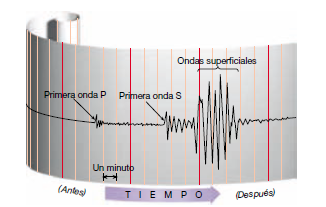

La idea detrás de realizar un metodo DBSCAN con distancia de Mahalanobis esta en que al tomar las caracteristicas de los sismos. tales como su ubicación , su profundidad y su magnitud presenten relaciones intrinsecas que permitan al menos diferenciar dos eventos caracteristicos de un sismo

In [46]:
#se importan los modulos de sklearn model selection
#por si se desea realizar otro metodo
from sklearn.model_selection import train_test_split
#Importar DBSCAN
from sklearn.cluster import DBSCAN
#Importar metricas para calcular la distancia mahalanobis
from sklearn.metrics import pairwise_distances
#Importar la metrica mahalanobis
from scipy.spatial.distance import mahalanobis
#Separación en conjunto de entrenamiento y prueba
X_train, X_test , Y_train , Y_test = train_test_split(X, Y , random_state=40)
#se usa y se escala el conjunto de prueba para reducir el sesgo
Scaler=StandardScaler().fit(X_train)
X_train_scaled=Scaler.transform(X_train)
Vector=X_train_scaled[:,:]

#Se calcula la matriz de covarianza
V= np.cov(Vector.T)
#se calcula la inversa de la matriz de covarianza
Inversa= np.linalg.inv(V)
#se calcula la distancia de mahalanobis del conjunto
#con la metrica de mahalanobis y la matriz inversa de covarianza
dist_mahalanobis= pairwise_distances(Vector, metric=mahalanobis, VI=Inversa)


vivo


In [47]:
#Se importa pdist,squareform, mahalanobis para determinar la
#distancia del primer punto con el resto del conjunto
from scipy.spatial.distance import pdist, squareform, mahalanobis
D= squareform(pdist(Vector, lambda u, v: mahalanobis(u,v,Inversa)))

In [130]:
DistanciaM= np.mean(D)/2
print(DistanciaM)

1.246622786473027


se toma el valor promedio de todas las distancias con 
respecto al primer punto y se dividen en dos
para obtener el epsilon adecuando con respecto
a la metrica de mahalanobis por ende la distancia minima entre dos puntos sera $\epsilon=1.246622786473027$ se planteo un minimo de 8 vecinos aunque se tienen dudas. el razpnamiento se basa en que la magnitud al ser la unidad de energia promedio liberada por el sismo independientemente si es un tipo de Onda u otra se deben tomar la fracción mas corta para garantizar que esas minimas distancias y vecinos sean del mismo tipo de Onda. 

### Realizando DBSCAN 
se llevan los parametros calculados al objeto y se realiza el agrupamiento en este caso se hicieron dos agrupamientos con la distancia recortada a la mitad (Imagen a la izquierda) el cual termino con 2 clusters y un silhouette score de 0.5108719336932268. Al tomar la distancia de mahalanobis normal se tiene solo 1 cluster y un silhouette score de 0.7111278025381964

In [141]:
print("vivo")
#Se llama el objeto DBSCAN con la distancia epsilon y el minimo de vecinos
#para construir las agrupaciones
dbscan= DBSCAN(eps=DistanciaM, min_samples=8, metric='precomputed')
#se establecen las etiquetas de los respectivos clusters con la distancia de mahalanobis del conjunto
labels= dbscan.fit_predict(dist_mahalanobis)

vivo


In [142]:
print(f"Número de clústeres: {len(set(labels)) - (1 if -1 in labels else 0)}")
print(f"Etiquetas de los puntos: {labels}")

Número de clústeres: 2
Etiquetas de los puntos: [ 0  0  0 ...  0  0 -1]


In [146]:
from sklearn.metrics import silhouette_score
silhouette_score(Vector, labels)

0.5108719336932268

In [217]:
etiqueta=dbscan.labels_

[ 0  0  0 ...  0  0 -1]


In [240]:
DistanciaM2=np.mean(D)
dbscan2= DBSCAN(eps=DistanciaM2, min_samples=10, metric='precomputed')
labels2= dbscan2.fit_predict(dist_mahalanobis)
print(f"Número de clústeres: {len(set(labels2)) - (1 if -1 in labels2 else 0)}")
print(f"Etiquetas de los puntos: {labels2}")

Número de clústeres: 1
Etiquetas de los puntos: [0 0 0 ... 0 0 0]


In [251]:
silhouette_score(Vector, labels2)

0.7111278025381964

In [242]:
etiqueta2=dbscan2.labels_

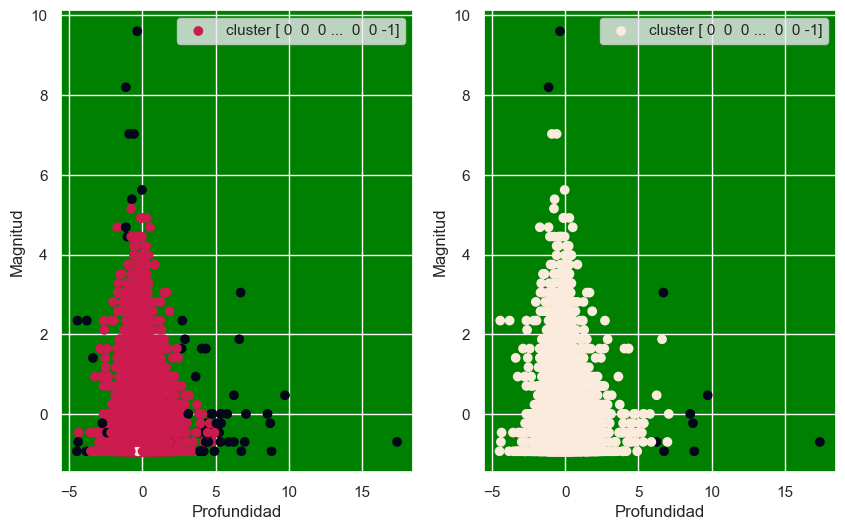

In [252]:
figap, axsclus= plt.subplots(nrows=1,ncols=2,figsize=(10,6))

#se llama a la lista de labels y se le da un color a cada cluster con respecto a su etiqueta las dispersiones son con respecto
axsclus[0].scatter(Vector[:,2],Vector[:,3],c=labels,label=f'cluster {etiqueta}')
axsclus[0].set_xlabel('Profundidad')
axsclus[0].set_ylabel('Magnitud')
axsclus[0].legend()
axsclus[0].set_facecolor('Green')


axsclus[1].scatter(Vector[:,2],Vector[:,3],c=labels2,label=f'cluster {etiqueta}')
axsclus[1].set_xlabel('Profundidad')
axsclus[1].set_ylabel('Magnitud')
axsclus[1].legend()
axsclus[1].set_facecolor('Green')


In [198]:
'''df['MagnitudeNorm']=(df['Magnitude']-df['Magnitude'].mean())/(df['Magnitude'].std())
df['DepthNorm']=(df['Depth/Km']-df['Depth/Km'].mean())/(df['Depth/Km'].std())
df['LatitudeNorm']=(df['Latitude']-df['Latitude'].mean())/(df['Latitude'].std())
df['LongitudeNorm']=(df['Longitude']-df['Longitude'].mean())/(df['Longitude'].std())
df['MagnitudeInt']=df['Magnitude'].astype(int)
diagrama caja y bigotes de datos normalizados
sns.set()
gboxNorm, axes = plt.subplots(2, 2)
sns.boxplot(data=df,y='MagnitudeNorm',ax=axes[0,0],color='green')
sns.boxplot(data=df,y='LongitudeNorm',ax=axes[0,1],color='navy')
sns.boxplot(data=df,y='DepthNorm',ax=axes[1,0],color='orange')
sns.boxplot(data=df,y='LatitudeNorm',ax=axes[1,1],color='red')
def AproxGra(dfa,col,dists):
    dist=dists
    paradist= dist.fit(data=dfa[col])
    xd=np.linspace(dfa[col].min(),dfa[col].max(),len(dfa))
    yd=dist.pdf(xd,*paradist)
    return xd, yd, paradist

xDepth,yDepth,pDepth = AproxGra(df,'Depth/Km',stats.t)
xLon,yLon,pLon = AproxGra(df,'Longitude',stats.t)
xLat,yLat,pLat = AproxGra(df,'Longitude',stats.t)
plt.plot(xDepth,yDepth,label='energias 6-12',color='navy')
sns.kdeplot(data=df, x='Depth/Km', label='original data', color='red')'''

"df['MagnitudeNorm']=(df['Magnitude']-df['Magnitude'].mean())/(df['Magnitude'].std())\ndf['DepthNorm']=(df['Depth/Km']-df['Depth/Km'].mean())/(df['Depth/Km'].std())\ndf['LatitudeNorm']=(df['Latitude']-df['Latitude'].mean())/(df['Latitude'].std())\ndf['LongitudeNorm']=(df['Longitude']-df['Longitude'].mean())/(df['Longitude'].std())\ndf['MagnitudeInt']=df['Magnitude'].astype(int)\ndiagrama caja y bigotes de datos normalizados\nsns.set()\ngboxNorm, axes = plt.subplots(2, 2)\nsns.boxplot(data=df,y='MagnitudeNorm',ax=axes[0,0],color='green')\nsns.boxplot(data=df,y='LongitudeNorm',ax=axes[0,1],color='navy')\nsns.boxplot(data=df,y='DepthNorm',ax=axes[1,0],color='orange')\nsns.boxplot(data=df,y='LatitudeNorm',ax=axes[1,1],color='red')\ndef AproxGra(dfa,col,dists):\n    dist=dists\n    paradist= dist.fit(data=dfa[col])\n    xd=np.linspace(dfa[col].min(),dfa[col].max(),len(dfa))\n    yd=dist.pdf(xd,*paradist)\n    return xd, yd, paradist\n\nxDepth,yDepth,pDepth = AproxGra(df,'Depth/Km',stats.t)\

### CONCLUSION

## Se tiene en este caso que el metodo no fue determinante pues incluso si se pudo tener la separación de dos componentes no se puede decir algo determinante pues aunque los silouette score son mas o menos decentes no son fiables para decir que puedan se pueda dar la interpretación física deseada, esto pudo darse por el area de los datos, pues italia no es un lugar de mucha actividad sismica por lo que la mayoria de sus eventos tal vez no suelan escalar los diferentes tipos de ondas. Se plantean otro tipo de clustering basados en modelos o kmeans, tal vez son otro set de datos con un dato de gap que parece ser la separación temporal entre los tipos de ondas y hacer una reducción de dimensionalidad 